In [20]:
def manhattan(v1, v2):
    return sum([abs(a - b) for a, b in zip(v1, v2)])


def euclidean(v1, v2):
    return sum([(a - b) ** 2 for a, b in zip(v1, v2)]) ** (1 / 2)


def chebyshev(v1, v2):
    return max([abs(a - b) for a, b in zip(v1, v2)])


metrics = {
    "euclidean": euclidean,
    "chebyshev": chebyshev,
    "manhattan": manhattan,
}

In [21]:
import math

def uniform(u):
    if abs(u) < 1:
        return 1 / 2
    return 0


def triangular(u):
    if abs(u) < 1:
        return 1 - abs(u)
    return 0


def epanechnikov(u):
    if abs(u) < 1:
        return 3 / 4 * (1 - u * u)
    return 0


def quartic(u):
    if abs(u) < 1:
        return 15 / 16 * (1 - u * u) ** 2
    return 0


def triweight(u):
    if abs(u) < 1:
        return 35 / 32 * (1 - u * u) ** 3
    return 0


def tricube(u):
    if abs(u) < 1:
        return 70 / 81 * (1 - abs(u) ** 3) ** 3
    return 0


def gaussian(u):
    return 1 / (math.sqrt(2 * math.pi)) * math.e ** (-0.5 * u * u)


def cosine(u):
    if abs(u) < 1:
        return math.pi / 4 * math.cos(math.pi / 2 * u)
    return 0


def logistic(u):
    return 1 / (math.e ** u + 2 + math.e ** (-u))


def sigmoid(u):
    return (2 / math.pi) * (1 / (math.e ** u + math.e ** (-u)))


kernels = {
    "uniform": uniform,
    "triangular": triangular,
    "epanechnikov": epanechnikov,
    "quartic": quartic,
    "triweight": triweight,
    "tricube": tricube,
    "gaussian": gaussian,
    "cosine": cosine,
    "logistic": logistic,
    "sigmoid": sigmoid,
}

In [22]:
import numpy as np


class KnnRegressor:

    def __init__(self, metric="euclidean", kernel="uniform", win_type="fixed", k=5, class_count=1):
        self.data = []
        self.metric = metric
        self.kernel = kernel
        self.win_type = win_type
        self.k = k
        self.class_count = class_count

    def fit(self, data):
        self.data = data.to_numpy()

    def predict(self, query):
        N = len(self.data)
        dists = []
        for row in self.data:
            d = metrics[self.metric](row[:-self.class_count], query)
            dists.append((d, row[-self.class_count:]))

        y_weights = []
        weights = []
        dists = sorted(dists, key=lambda x: x[0])

        for dist in dists:
            if dist[0] != 0 and (self.k == 0 or (self.win_type == "variable" and dists[self.k][0] == 0)):
                k = 0
            else:
                if self.win_type == "fixed":
                    u = dist[0] / self.k if self.k != 0 else 0
                elif self.win_type == "variable":
                    u = dist[0] / dists[self.k][0] if dists[self.k][0] != 0 else 0

                k = kernels[self.kernel](u)

            weights.append(k)
            y_weights.append(np.array(dist[1]) * k)

        res = []
        if sum(weights) == 0:
            for i in range(1, self.class_count + 1):
                res.insert(0, sum(row[-i] for row in self.data) / N)
        else:
            for i in range(1, self.class_count + 1):
                res.insert(0, sum([w[-i] for w in y_weights]) / sum(weights))

        return res

In [23]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import numpy as np
import time

In [24]:
def leave_one_out_cv(regressor, data, class_count):
    y_pred = []
    y_true = []
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(data):
        regressor.fit(data.iloc[train_index])

        test = np.array(data.iloc[test_index])[0][:-class_count]
        if class_count == 1:
            y_true.append(np.array(data.iloc[test_index])[0][-1])
            y_pred.append(np.round(regressor.predict(test)[0]))
        else:
            y_true.append(np.argmax(np.array(data.iloc[test_index])[0][-class_count:]))
            pred = regressor.predict(test)
            y_pred.append(np.argmax(pred))

    return f1_score(y_true, y_pred, average="weighted")

In [25]:
def grid_search_cv(regressor, grid_params, data, class_count, verbose=False):
    params_list = list(grid_params.keys())
    best_score = 0.0
    best_params = {}

    for params in (dict(zip(grid_params.keys(), values)) for values in product(*grid_params.values())):
                knn = regressor(**params, class_count=class_count)
                score = leave_one_out_cv(knn, data, class_count)

                if verbose:
                    format_list = list(params.values())
                    format_list.append(score)
                    print('%12s : %12s : %10s : %3d = %7.5f' % tuple(format_list))

                if score > best_score:
                    best_score = score
                    for p_name in params_list:
                        best_params[p_name] = params[p_name]

    return best_params, best_score

In [26]:
def plot(neighbors_count, f_score):
    plt.plot(neighbors_count, f_score, color='blue', linestyle='solid', label='sin(x)')
    plt.xlabel('Neighbors count')
    plt.ylabel('F1 score')
    plt.show()

In [27]:
N = 500
# load data
# https://www.openml.org/d/183
dataset = pd.read_csv("ds.csv")[:N]

V1 = {'F': 0, 'I': 1, 'M': 2}
ClassLabels = {1: 0.0, 2: 1.0, 3: 2.0}
dataset['V1'] = dataset['V1'].map(V1)
dataset['Class'] = dataset['Class'].map(ClassLabels)

X = dataset.drop(dataset.columns[-1], axis=1)
y = dataset[dataset.columns[-1]]

In [28]:
# normalize data
columns = list(X.columns)
columns_bins = {}
for column in columns[1:]:
    X[column], bins = pd.qcut(X[column], 5, retbins=True, labels=False)
    columns_bins[column] = bins

In [29]:
# NAIVE
class_count = 1
normalized_dataset = X.join(y)

print(normalized_dataset.head(10))

   V1  V2  V3  V4  V5  V6  V7  V8  Class
0   2   1   1   0   1   1   1   1    2.0
1   2   0   0   0   0   0   0   0    0.0
2   0   2   2   2   2   2   2   2    1.0
3   2   1   1   1   1   1   1   1    1.0
4   1   0   0   0   0   0   0   0    0.0
5   1   1   0   0   1   1   1   1    0.0
6   0   2   2   2   2   1   2   3    2.0
7   0   2   2   1   2   2   2   2    2.0
8   2   1   1   1   1   1   1   1    1.0
9   0   2   2   2   2   2   2   3    2.0


{'metric': 'euclidean', 'kernel': 'gaussian', 'win_type': 'variable', 'k': 13}
0.7493806818181817
280.22393798828125


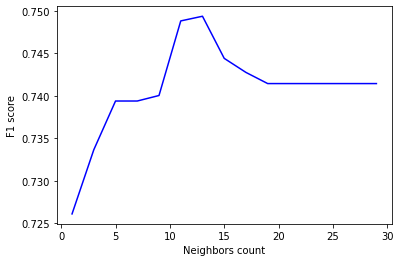

In [30]:
start = time.time()

k_range = range(1, 30, 2)
grid_params = {
    'metric': ['euclidean', 'manhattan'],
    'kernel': ['uniform', 'gaussian'],
    'win_type': ['variable'],
    'k': k_range,
}

best_params, best_score = grid_search_cv(KnnRegressor, grid_params, normalized_dataset, class_count)
print(best_params)
print(best_score)

best_params.pop('k', None)

scores = []
for k in k_range:
    knn = KnnRegressor(**best_params, k=k, class_count=class_count)
    scores.append(leave_one_out_cv(knn, normalized_dataset, class_count))

plot([k for k in k_range], scores)

print(time.time() - start)

In [31]:
# ONE HOT
class_count = 3
y = pd.get_dummies(y, dtype=float)
normalized_dataset = X.join(y)
del X

print(normalized_dataset.head(10))

   V1  V2  V3  V4  V5  V6  V7  V8  0.0  1.0  2.0
0   2   1   1   0   1   1   1   1  0.0  0.0  1.0
1   2   0   0   0   0   0   0   0  1.0  0.0  0.0
2   0   2   2   2   2   2   2   2  0.0  1.0  0.0
3   2   1   1   1   1   1   1   1  0.0  1.0  0.0
4   1   0   0   0   0   0   0   0  1.0  0.0  0.0
5   1   1   0   0   1   1   1   1  1.0  0.0  0.0
6   0   2   2   2   2   1   2   3  0.0  0.0  1.0
7   0   2   2   1   2   2   2   2  0.0  0.0  1.0
8   2   1   1   1   1   1   1   1  0.0  1.0  0.0
9   0   2   2   2   2   2   2   3  0.0  0.0  1.0


{'metric': 'manhattan', 'kernel': 'gaussian', 'win_type': 'fixed', 'k': 1.0}
0.737825489267458
438.6692740917206


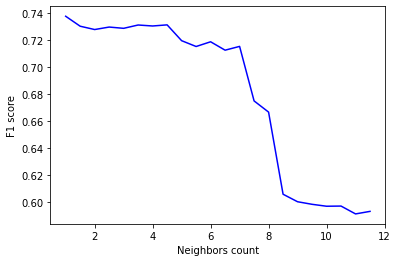

In [32]:
start = time.time()

k_range = np.arange(1.0, 12.0, 0.5)
grid_params = {
    'metric': ['euclidean', 'manhattan'],
    'kernel': ['uniform', 'gaussian'],
    'win_type': ['fixed'],
    'k': k_range,
}

best_params, best_score = grid_search_cv(KnnRegressor, grid_params, normalized_dataset, class_count)
print(best_params)
print(best_score)

best_params.pop('k', None)

scores = []
for k in k_range:
    knn = KnnRegressor(**best_params, k=k, class_count=class_count)
    scores.append(leave_one_out_cv(knn, normalized_dataset, class_count))

plot([k for k in k_range], scores)

print(time.time() - start)
